# LSTM from Scratch for TA

## import packages

In [1]:
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

## Define Function of Activation Function

In [2]:
#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

## Define LSTM Class

In [3]:
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs 
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*
                               self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

## Change the Indicators Here!

In [4]:
#hyperparameters
epochs  = 10
nc      = 10 #units

#datasets
name_dataset = 'UNVR-long'

column_dataset_obs = 'Close'

## Import Dataset

In [5]:
df = pd.read_csv('../Datasets/'+name_dataset+'.csv')
# df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,7760.0,7760.0,7760.0,7760.0,6857.312500,0
1,2017-01-03,7800.0,7840.0,7760.0,7765.0,6861.731445,5014500
2,2017-01-04,7770.0,8070.0,7770.0,8040.0,7104.741699,10642000
3,2017-01-05,8100.0,8110.0,8005.0,8110.0,7166.599121,10493500
4,2017-01-06,8060.0,8190.0,7965.0,8120.0,7175.434570,5400500
...,...,...,...,...,...,...,...
1257,2021-12-24,4090.0,4210.0,4080.0,4200.0,4200.000000,11979500
1258,2021-12-27,4200.0,4230.0,4170.0,4210.0,4210.000000,7238100
1259,2021-12-28,4210.0,4230.0,4180.0,4180.0,4180.000000,7006900
1260,2021-12-29,4180.0,4190.0,4120.0,4120.0,4120.000000,9030700


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1.262000e+03
mean,8279.290808,8355.285261,8188.458796,8270.229794,7645.417650,1.299244e+07
std,1727.802437,1727.550235,1728.247183,1732.949401,1435.155938,1.287545e+07
min,3800.000000,3870.000000,3800.000000,3820.000000,3765.546387,0.000000e+00
25%,7706.250000,7770.000000,7600.000000,7650.000000,7228.263672,6.784875e+06
50%,8655.000000,8737.500000,8550.000000,8640.000000,7973.754394,1.022120e+07
75%,9530.000000,9600.000000,9440.000000,9530.000000,8617.775147,1.519868e+07
max,11235.000000,11620.000000,11180.000000,11180.000000,10056.169922,2.509038e+08


In [7]:
new_df = df.reset_index()[column_dataset_obs]
new_df

0       7760.0
1       7765.0
2       8040.0
3       8110.0
4       8120.0
         ...  
1257    4200.0
1258    4210.0
1259    4180.0
1260    4120.0
1261    4110.0
Name: Close, Length: 1262, dtype: float64

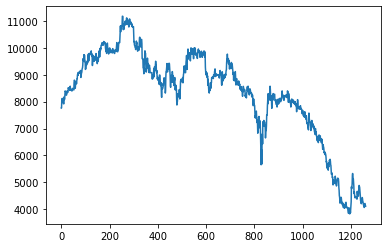

In [8]:
plt.plot(new_df)

## MinMax Scaler

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
# new_df

In [10]:
xs = new_df

In [11]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
Ts      = 1
x_dim   = 4
alpha   = 0.01 #learningrate

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   



## Splitting Training and Testing

In [12]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size

In [13]:
training_size, test_size

(1009, 253)

In [14]:
X_train = xt[:training_size, 0:x_dim]     
y_train = xt[:training_size, x_dim:x_dim+1]  
X_test = xt[-test_size:, 0:x_dim]     
y_test = xt[-test_size:, x_dim:x_dim+1]

## Build LSTM Model

In [15]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.update(alpha)
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.09269369250530787
------------- 2 -------------
0.09247222379722932
------------- 3 -------------
0.09224924653184526
------------- 4 -------------
0.09202443284652156
------------- 5 -------------
0.09179743472802178
------------- 6 -------------
0.0915678792224056
------------- 7 -------------
0.09133536357120806
------------- 8 -------------
0.09109945026520491
------------- 9 -------------
0.09085966198841638
------------- 10 -------------
0.09061547642625865


In [17]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

out=scaler.inverse_transform(out).tolist()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [26]:
out

[[4602.795486321489, 7625.0],
 [4605.052225124806, 7475.0],
 [4604.146649485373, 7424.999999999999],
 [4604.539317908935, 7450.0],
 [4604.2067596529205, 7350.0],
 [4602.271565836028, 7350.0],
 [4600.562606878653, 7475.0],
 [4601.126269621519, 7375.000000000001],
 [4600.981734982719, 7200.0],
 [4599.49976561277, 7200.0],
 [4599.00320701728, 7175.0],
 [4597.494296901062, 7200.0],
 [4595.110874425212, 7100.0],
 [4595.071394050578, 7025.0],
 [4593.46545834434, 7000.0],
 [4592.761710237069, 6950.0],
 [4591.013483373139, 7500.0],
 [4591.074262217705, 7575.000000000001],
 [4597.021394728626, 7399.999999999999],
 [4597.340910296661, 7325.0],
 [4602.115423650318, 7275.0],
 [4601.882252105394, 7250.0],
 [4598.992562078264, 7250.0],
 [4597.726038145844, 7125.0],
 [4596.714807428175, 7075.0],
 [4594.874600016427, 6925.0],
 [4593.747640834961, 7025.0],
 [4590.7689716485565, 7000.0],
 [4591.008500099352, 7175.0],
 [4589.485579121783, 7300.0],
 [4592.993502511832, 7225.0],
 [4594.049176103583, 7100.0

## Report Performance of LSTM Predictions

In [18]:
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [19]:
# mse = mean_squared_error(y, predictions)
# print('MSE: '+str(mse))
print('epoch: ' + str(epochs))
print('units: ' + str(nc))

rmse = math.sqrt(mean_squared_error(np.array(out)[:,1], np.array(out)[:,0]))
print('RMSE: '+ str("{:.2f}".format(rmse)))
mae = mean_absolute_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAE: '+ str("{:.2f}".format(mae)))
mape = mean_absolute_percentage_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAPE: '+ str("{:.2f}".format(mape*100)))

epoch: 10
units: 10
RMSE: 1421.96
MAE: 1083.25
MAPE: 17.57


## Visualize Test Data the Prediction and Real Stock

In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

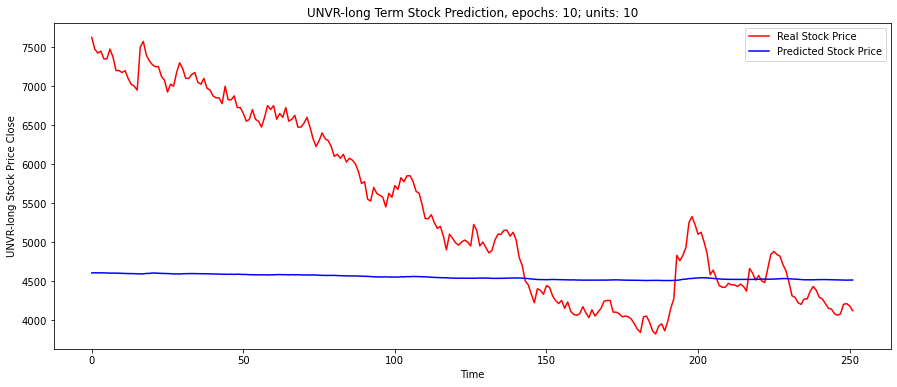

In [21]:
plt.figure()
plt.plot(np.array(out)[:,1], color = 'red', label = 'Real Stock Price')
plt.plot(np.array(out)[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title(name_dataset +' Term Stock Prediction, epochs: '+ str(epochs) +'; units: '+str(nc))
plt.xlabel('Time')
plt.ylabel(name_dataset +' Stock Price '+ column_dataset_obs)
plt.legend()

## Save as a new Dataset

In [22]:
real_price = np.array(out)[:,1]
close_lstm = np.array(out)[:,0]

In [23]:
new_data = {'real_price': real_price,
            'Close_LSTM': close_lstm}


In [24]:
df_new_data = pd.DataFrame(new_data, columns = ['real_price', 'Close_LSTM'])


In [25]:
df_new_data.to_csv('../Datasets/dataset after prediction/'+name_dataset
                   +'_LSTM_'+ str(epochs) +'_'+ str(nc) + '.csv', index=False)